### 1. Load Datasets

#### 1-1. Load and extract data

In [1]:
from pyspark.sql import SparkSession

# Create a spark session
spark = SparkSession.builder.config('spark.ui.showConsoleProgress', 'false').config('spark.driver.memory', '5g').getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Read and combine input files
df_list = []
for i in range(13, 27):
    df_list.append(spark.read.text('d04_text_station_5min_2023_02_'+str(i)+'.txt'))

df0 = df_list[0]
for i in range(1, len(df_list)):
    df0 = df0.union(df_list[i])

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/14 15:59:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Extract highway 101 north bound data
df1 = df0.filter(df0.value.rlike("^../../....\s..:..:..,......,.,101,N.*"))
df1.show(5, truncate=150)

+------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                 value|
+------------------------------------------------------------------------------------------------------------------------------------------------------+
|02/13/2023 00:00:00,400001,4,101,N,ML,.265,50,100,51,.0083,71,10,5,.0034,76.5,1,10,15,.0092,74,1,10,10,.0098,72,1,10,12,.0113,69.2,1,10,9,.0078,64....|
|02/13/2023 00:00:00,400007,4,101,N,ML,.365,50,0,109,.0225,68.6,10,20,.0237,71.5,0,10,35,.027,70.5,0,10,31,.0353,67,0,10,18,.0244,66,0,10,5,.002,64....|
|02/13/2023 00:00:00,400010,4,101,N,ML,.47,38,75,43,.0071,65.2,10,0,0,74.8,1,10,7,.004,71,1,10,20,.0129,67.4,1,8,16,.0115,59.9,0,,,,,0,,,,,0,,,,,0,,...|
|02/13/2023 00:00:00,400014,4,101,N,ML,.29,50,60,57,.0101,68.6,10,6,.0047,75.8,0,1

#### 1-2. Structure dataframe

In [3]:
from pyspark.sql.functions import split, col, when, to_timestamp, to_date, dayofweek, hour, minute

# Construct the date/time columns
df1 = df1.withColumn('timestamp', split(df1['value'], ',').getItem(0)) \
         .withColumn('timestamp',to_timestamp('timestamp', 'MM/dd/yyyy HH:mm:ss')) \
         .withColumn('date', to_date(col('timestamp'))) \
         .withColumn('dayofweek', dayofweek(col('date'))) \
         .withColumn('hour', hour(col('timestamp'))) \
         .withColumn('minute', minute(col('timestamp')))

# Construct the holiday column
df1 = df1.withColumn('holiday', when((df1.dayofweek == 1) | (df1.dayofweek == 7) | (df1.date == '2023-02-20'), 'Y').otherwise('N'))

# Construct overall traffic attributes
df1 = df1.withColumn('station', split(df1['value'], ',').getItem(1)).withColumn('district', split(df1['value'], ',').getItem(2)) \
         .withColumn('freeway', split(df1['value'], ',').getItem(3)).withColumn('direction', split(df1['value'], ',').getItem(4)) \
         .withColumn('lane_type', split(df1['value'], ',').getItem(5)).withColumn('station_length', split(df1['value'], ',').getItem(6)) \
         .withColumn('samples', split(df1['value'], ',').getItem(7)).withColumn('pct_observed', split(df1['value'], ',').getItem(8)) \
         .withColumn('total_flow', split(df1['value'], ',').getItem(9)).withColumn('avg_occupancy', split(df1['value'], ',').getItem(10)) \
         .withColumn('avg_speed', split(df1['value'], ',').getItem(11))

# Construct lane specific columns
for i in range(1, 11):
    item_no = [7 + 5*i + j for j in range(5)]
    df1 = df1.withColumn('lane_'+str(i)+'_samples', split(df1['value'], ',').getItem(item_no[0])) \
             .withColumn('lane_'+str(i)+'_flow', split(df1['value'], ',').getItem(item_no[1])) \
             .withColumn('lane_'+str(i)+'_avg_occ', split(df1['value'], ',').getItem(item_no[2])) \
             .withColumn('lane_'+str(i)+'_avg_speed', split(df1['value'], ',').getItem(item_no[3])) \
             .withColumn('lane_'+str(i)+'_observed', split(df1['value'], ',').getItem(item_no[4]))

# Construct the target (label) column
df1 = df1.withColumn('traffic_condition', when(df1.avg_speed < 40, 2).when((df1.avg_speed >= 40)&(df1.avg_speed < 60), 1).when(df1.avg_speed >= 60, 0).otherwise(-1))

df1 = df1.select(df1.columns[1:]).orderBy('timestamp', 'station')

#### 1-3. Cast column data types

In [4]:
integer_columns = ['samples', 'pct_observed', 'total_flow', 'traffic_condition']
double_columns = ['station_length', 'avg_occupancy', 'avg_speed']
for i in range(1, 11):
    integer_columns += ['lane_'+str(i)+'_samples', 'lane_'+str(i)+'_flow',  'lane_'+str(i)+'_observed']
    double_columns += ['lane_'+str(i)+'_avg_occ', 'lane_'+str(i)+'_avg_speed']

# Integer columns
for column in integer_columns:
    df1 = df1.withColumn(column, df1[column].cast('integer'))

# Double columns
for column in double_columns:
    df1 = df1.withColumn(column, df1[column].cast('double'))
    
df1.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- holiday: string (nullable = false)
 |-- station: string (nullable = true)
 |-- district: string (nullable = true)
 |-- freeway: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- lane_type: string (nullable = true)
 |-- station_length: double (nullable = true)
 |-- samples: integer (nullable = true)
 |-- pct_observed: integer (nullable = true)
 |-- total_flow: integer (nullable = true)
 |-- avg_occupancy: double (nullable = true)
 |-- avg_speed: double (nullable = true)
 |-- lane_1_samples: integer (nullable = true)
 |-- lane_1_flow: integer (nullable = true)
 |-- lane_1_avg_occ: double (nullable = true)
 |-- lane_1_avg_speed: double (nullable = true)
 |-- lane_1_observed: integer (nullable = true)
 |-- lane_2_samples: integer (nullable = true)
 |-- lane_2_flow: i

#### 1-4. Target class statistics

In [5]:
c0 = df1.select('*').where(df1.traffic_condition == 0).count()
c1 = df1.select('*').where(df1.traffic_condition == 1).count()
c2 = df1.select('*').where(df1.traffic_condition == 2).count()

print(f"            Normal (Class 0): {c0:8} instances")
print(f"Slightly congested (Class 1): {c1:8} instances")
print(f"         Congested (Class 2): {c2:8} instances")

            Normal (Class 0):  1416535 instances
Slightly congested (Class 1):   140295 instances
         Congested (Class 2):    27746 instances


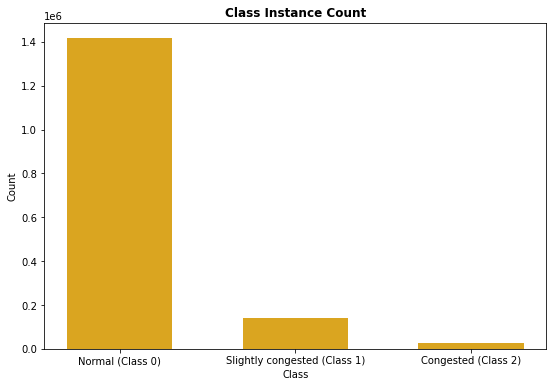

In [6]:
import matplotlib.pyplot as plt 

plt.figure(figsize =(9, 6))
plt.bar(['Normal (Class 0)', 'Slightly congested (Class 1)', 'Congested (Class 2)'], [c0, c1, c2], color='goldenrod', width=0.6)
plt.xticks(fontsize=10)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Instance Count', fontweight ="bold")
plt.show()

#### 1-5. Numerical attribute statistics (partial)

In [7]:
df1.describe(['avg_speed', 'total_flow', 'station_length', 'avg_occupancy']).show()

+-------+------------------+------------------+-------------------+--------------------+
|summary|         avg_speed|        total_flow|     station_length|       avg_occupancy|
+-------+------------------+------------------+-------------------+--------------------+
|  count|           1584576|           2057075|            1584576|             2057075|
|   mean| 64.33039942546299|169.67859314803786| 0.4370229007633489| 0.04322411093421779|
| stddev|6.3958047270452205|159.26961217040719|0.22570913655204336|0.048815453669553685|
|    min|               3.0|                 0|              0.045|                 0.0|
|    max|              81.2|              1015|               2.52|              0.9992|
+-------+------------------+------------------+-------------------+--------------------+



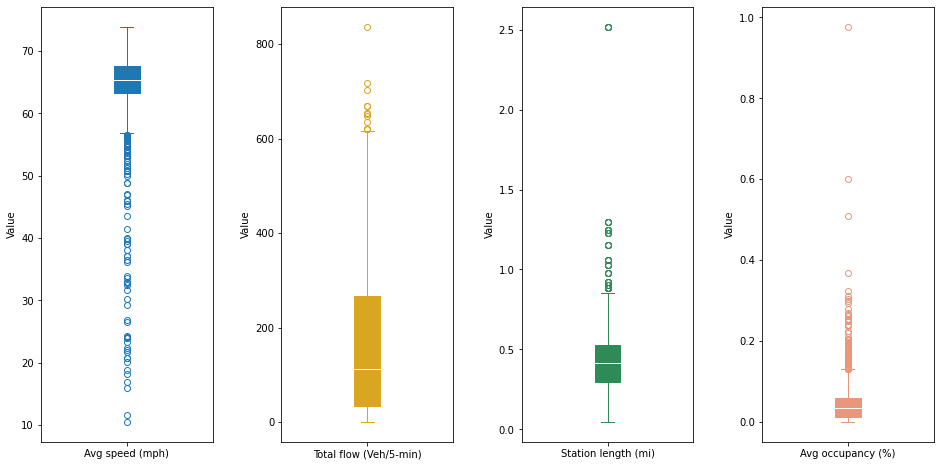

In [8]:
# Numecial attribute summary
avs = df1.select('avg_speed').na.drop().collect()
tof = df1.select('total_flow').na.drop().collect()
stl = df1.select('station_length').na.drop().collect()
avo = df1.select('avg_occupancy').na.drop().collect()

avs_d, tof_d, stl_d, avo_d = [], [], [], []
for i in range(len(avs)):
    if i % 1000 == 0:
        avs_d.append(avs[i][0])
for i in range(len(tof)):
    if i % 1000 == 0:
        tof_d.append(tof[i][0])
for i in range(len(stl)):
    if i % 1000 == 0:
        stl_d.append(stl[i][0])
for i in range(len(avo)):
    if i % 1000 == 0:
        avo_d.append(avo[i][0])

plt.figure(figsize =(16, 8))
plt.subplot(141)
plt.boxplot([avs_d], patch_artist=True,
            boxprops=dict(facecolor='tab:blue', color='tab:blue'), capprops=dict(color='tab:blue'), whiskerprops=dict(color='tab:blue'), 
            flierprops=dict(color='tab:blue', markeredgecolor='tab:blue'),medianprops=dict(color='white'))
plt.xticks(ticks=[1], labels=['Avg speed (mph)'])
plt.ylabel('Value')

plt.subplot(142)
plt.boxplot([tof_d], patch_artist=True,
            boxprops=dict(facecolor='goldenrod', color='goldenrod'), capprops=dict(color='goldenrod'), whiskerprops=dict(color='goldenrod'), 
            flierprops=dict(color='goldenrod', markeredgecolor='goldenrod'),medianprops=dict(color='white'))
plt.xticks(ticks=[1], labels=['Total flow (Veh/5-min)'])
plt.ylabel('Value')

plt.subplot(143)
plt.boxplot([stl_d], patch_artist=True,
            boxprops=dict(facecolor='seagreen', color='seagreen'), capprops=dict(color='seagreen'), whiskerprops=dict(color='seagreen'), 
            flierprops=dict(color='seagreen', markeredgecolor='seagreen'),medianprops=dict(color='white'))
plt.xticks(ticks=[1], labels=['Station length (mi)'])
plt.ylabel('Value')

plt.subplot(144)
plt.boxplot([avo_d], patch_artist=True,
            boxprops=dict(facecolor='darksalmon', color='darksalmon'), capprops=dict(color='darksalmon'), whiskerprops=dict(color='darksalmon'), 
            flierprops=dict(color='darksalmon', markeredgecolor='darksalmon'),medianprops=dict(color='white'))
plt.xticks(ticks=[1], labels=['Avg occupancy (%)'])
plt.ylabel('Value')

plt.subplots_adjust(wspace=0.4)
plt.show()

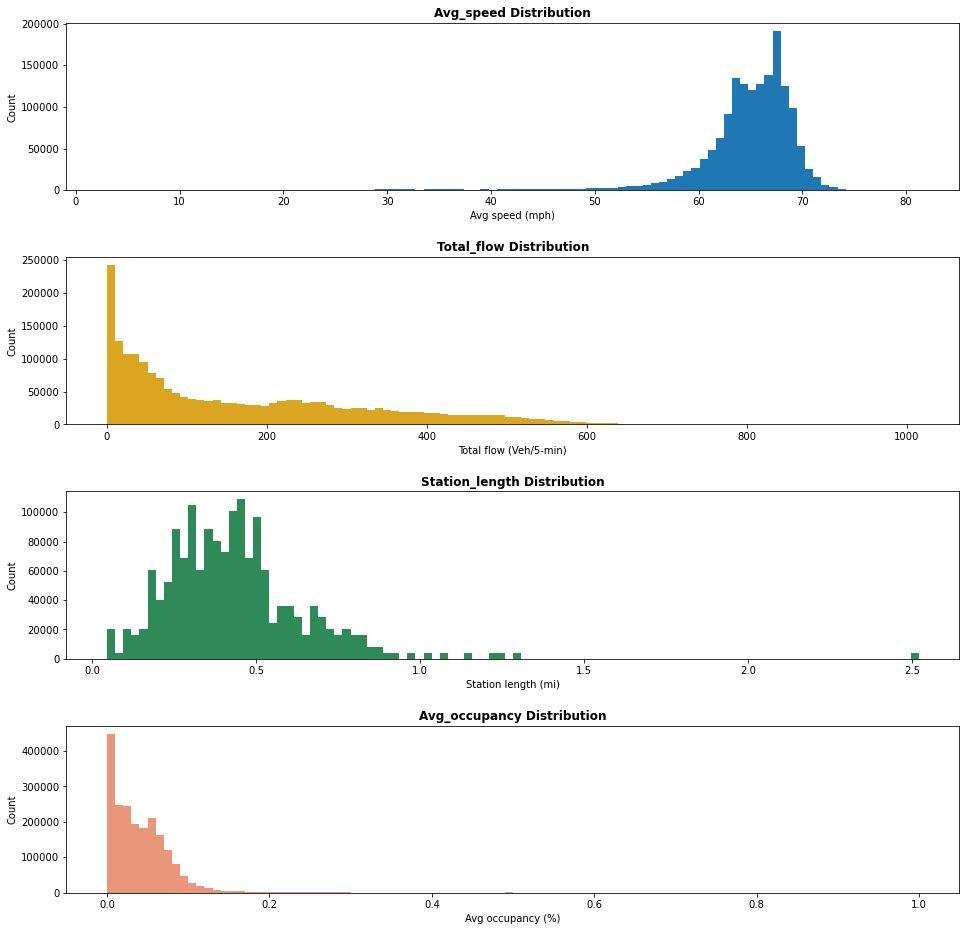

In [9]:
# Numecial attribute distribution
x1 = df1.select('avg_speed').where(~df1.avg_speed.isNull()).rdd.flatMap(lambda x: x).collect()
x2 = df1.select('total_flow').where(~df1.total_flow.isNull()).rdd.flatMap(lambda x: x).collect()
x3 = df1.select('station_length').where(~df1.station_length.isNull()).rdd.flatMap(lambda x: x).collect()
x4 = df1.select('avg_occupancy').where(~df1.avg_occupancy.isNull()).rdd.flatMap(lambda x: x).collect()

plt.figure(figsize =(16, 16))
plt.subplot(411)
plt.hist(x1, 100, color='tab:blue')
plt.xlabel('Avg speed (mph)')
plt.ylabel('Count')
plt.title('Avg_speed Distribution', fontweight ="bold")

plt.subplot(412)
plt.hist(x2, 100, color='goldenrod')
plt.xlabel('Total flow (Veh/5-min)')
plt.ylabel('Count')
plt.title('Total_flow Distribution', fontweight ="bold")

plt.subplot(413)
plt.hist(x3, 100, color='seagreen')
plt.xlabel('Station length (mi)')
plt.ylabel('Count')
plt.title('Station_length Distribution', fontweight ="bold")

plt.subplot(414)
plt.hist(x4, 100, color='darksalmon')
plt.xlabel('Avg occupancy (%)')
plt.ylabel('Count')
plt.title('Avg_occupancy Distribution', fontweight ="bold")

plt.subplots_adjust(hspace=0.4)
plt.show()

#### 1-6. Visualize initial data (partial)

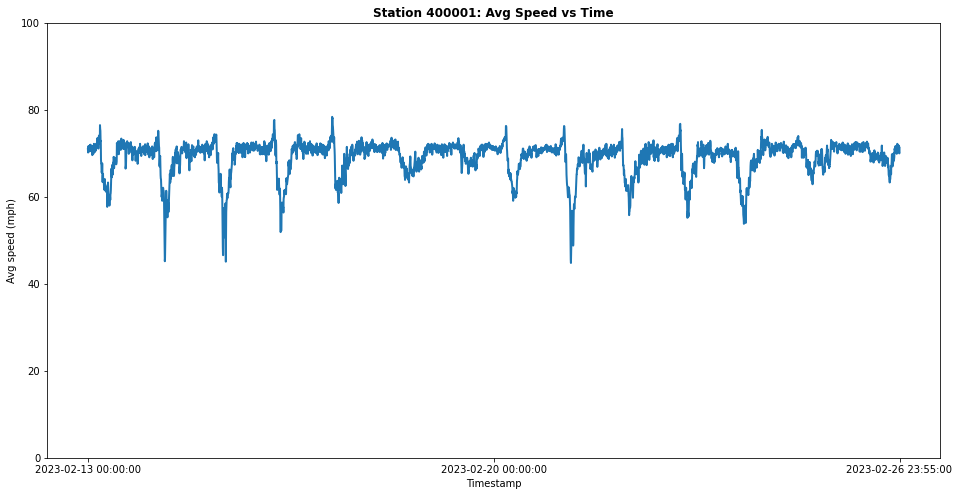

In [10]:
# Avg speed vs time plot
s = df1.select('avg_speed').where(df1.station == 400001).rdd.flatMap(lambda x: x).collect()
t = df1.select('timestamp').where(df1.station == 400001).rdd.flatMap(lambda x: x).collect()

plt.figure(figsize =(16, 8))
plt.plot(t, s, color='tab:blue', linewidth=2) 

plt.ylim([0, 100]) 
plt.xticks(ticks=[t[0], t[len(t)//2], t[-1]], labels=[t[0], t[len(t)//2], t[-1]])

plt.ylabel('Avg speed (mph)')
plt.xlabel('Timestamp')
plt.title('Station 400001: Avg Speed vs Time', fontweight ="bold")
plt.show()

###
### 2. Data Cleaning

#### 2-1. Incomplete and missing data

In [11]:
# Select relevant attributes to work with
df2 = df1.select('date', 'dayofweek', 'hour', 'minute', 'holiday', 'station', 'station_length', 'total_flow', 'avg_occupancy', 'avg_speed', 'traffic_condition').orderBy('timestamp', 'station')
df2.show(5, truncate=False)

+----------+---------+----+------+-------+-------+--------------+----------+-------------+---------+-----------------+
|date      |dayofweek|hour|minute|holiday|station|station_length|total_flow|avg_occupancy|avg_speed|traffic_condition|
+----------+---------+----+------+-------+-------+--------------+----------+-------------+---------+-----------------+
|2023-02-13|2        |0   |0     |N      |400001 |0.265         |51        |0.0083       |71.0     |0                |
|2023-02-13|2        |0   |0     |N      |400007 |0.365         |109       |0.0225       |68.6     |0                |
|2023-02-13|2        |0   |0     |N      |400010 |0.47          |43        |0.0071       |65.2     |0                |
|2023-02-13|2        |0   |0     |N      |400014 |0.29          |57        |0.0101       |68.6     |0                |
|2023-02-13|2        |0   |0     |N      |400039 |0.195         |57        |0.0099       |65.6     |0                |
+----------+---------+----+------+-------+------

In [12]:
# Find the number of null values for each column
print('Total instance count (before dropping null data):', df2.count())
print('\nNull value count:')
null_count = []
for column in df2.columns[:-1]:
    c = df2.filter(df2[column].isNull()).count()
    print(f'  Column {column:15} {c}')
    null_count.append(c)

Total instance count (before dropping null data): 2503872

Null value count:
  Column date            0
  Column dayofweek       0
  Column hour            0
  Column minute          0
  Column holiday         0
  Column station         0
  Column station_length  919296
  Column total_flow      446797
  Column avg_occupancy   446797
  Column avg_speed       919296


In [13]:
# Sample screenshot
df2.filter(df2['avg_speed'].isNull()).show(10)

+----------+---------+----+------+-------+-------+--------------+----------+-------------+---------+-----------------+
|      date|dayofweek|hour|minute|holiday|station|station_length|total_flow|avg_occupancy|avg_speed|traffic_condition|
+----------+---------+----+------+-------+-------+--------------+----------+-------------+---------+-----------------+
|2023-02-13|        2|   0|     0|      N| 401909|          null|      null|         null|     null|               -1|
|2023-02-13|        2|   0|     0|      N| 402867|          null|         2|       0.0026|     null|               -1|
|2023-02-13|        2|   0|     0|      N| 402868|          null|         8|       0.0072|     null|               -1|
|2023-02-13|        2|   0|     0|      N| 402873|          null|      null|         null|     null|               -1|
|2023-02-13|        2|   0|     0|      N| 402874|          null|        11|       0.0025|     null|               -1|
|2023-02-13|        2|   0|     0|      N| 40287

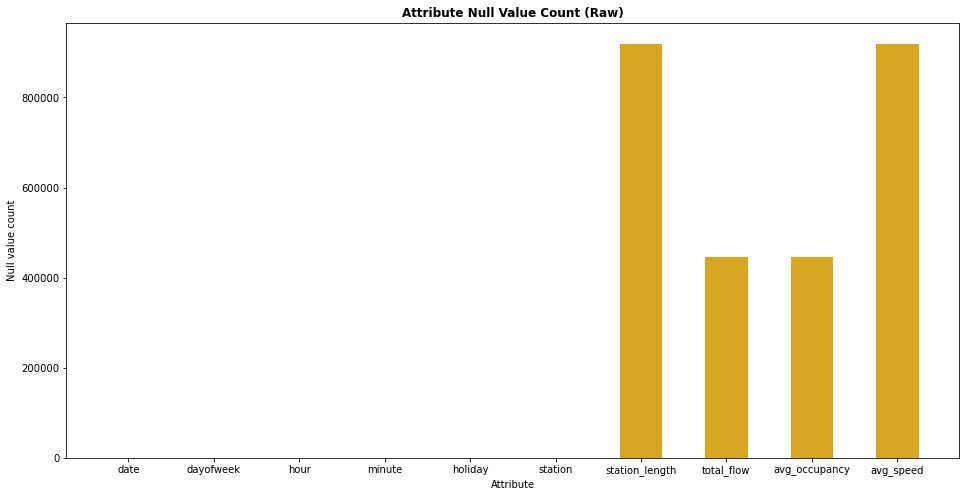

In [14]:
plt.figure(figsize =(16, 8))
plt.bar(['date', 'dayofweek', 'hour', 'minute', 'holiday', 'station', 'station_length', 'total_flow', 'avg_occupancy', 'avg_speed'], null_count, color='goldenrod', width=0.5)
plt.ylabel('Null value count')
plt.xlabel('Attribute')
plt.title('Attribute Null Value Count (Raw)', fontweight ="bold")
plt.show()

In [15]:
# Drop rows with null avg_speed
df2 = df2.na.drop(subset=['avg_speed']).cache()

print('New instance count (after dropping null data):', df2.count())
print('\nNull value count:')
for column in df2.columns[:-1]:
    print(f'  Column {column:15} {df2.filter(df2[column].isNull()).count()}')

New instance count (after dropping null data): 1584576

Null value count:
  Column date            0
  Column dayofweek       0
  Column hour            0
  Column minute          0
  Column holiday         0
  Column station         0
  Column station_length  0
  Column total_flow      0
  Column avg_occupancy   0
  Column avg_speed       0


#### 2-2. Noisy data

In [16]:
# Number of instances before regularizing outliers
print('Total instance count (before regularizing noisy data):', df2.count())
print()
print('original min(avg_speed) =', df2.agg({'avg_speed': 'min'}).collect()[0][0])
print('original avg(avg_speed) =', df2.agg({'avg_speed': 'avg'}).collect()[0][0])
print('original max(avg_speed) =', df2.agg({'avg_speed': 'max'}).collect()[0][0])

Total instance count (before regularizing noisy data): 1584576

original min(avg_speed) = 3.0
original avg(avg_speed) = 64.33039942546145
original max(avg_speed) = 81.2


In [17]:
# Compute IQR
from pyspark.sql.functions import percentile_approx

q = df2.select(percentile_approx('avg_speed', [0.25, 0.75])).collect()[0][0]
iqr = q[1] - q[0]
threshold = q[1] + 1.5*iqr    # Consider upper outliers only

In [18]:
# Replace outliers (avg speed > Q3 + 1.5IQR) with the threshold value
y1 = df2.select('avg_speed').collect()
df2 = df2.withColumn('avg_speed', when(df2.avg_speed > threshold, threshold).otherwise(df2.avg_speed))
y2 = df2.select('avg_speed').collect()

In [19]:
# Number of instances after regularizing outliers
print('New instance count (after regularizing noisy data):', df2.count())
print()
print('new min(avg_speed) =', df2.agg({'avg_speed': 'min'}).collect()[0][0])
print('new avg(avg_speed) =', df2.agg({'avg_speed': 'avg'}).collect()[0][0])
print('new max(avg_speed) =', df2.agg({'avg_speed': 'max'}).collect()[0][0])

New instance count (after regularizing noisy data): 1584576

new min(avg_speed) = 3.0
new avg(avg_speed) = 64.32875355931174
new max(avg_speed) = 74.60000000000001


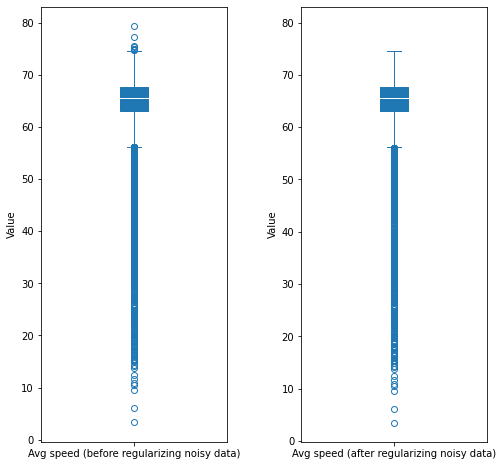

In [20]:
y1_d, y2_d = [], []
for i in range(len(y1)):
    if i % 100 == 0:
        y1_d.append(y1[i][0])
        y2_d.append(y2[i][0])

plt.figure(figsize =(8, 8))
plt.subplot(121)
plt.boxplot(y1_d, patch_artist=True,
            boxprops=dict(facecolor='tab:blue', color='tab:blue'), capprops=dict(color='tab:blue'), whiskerprops=dict(color='tab:blue'), 
            flierprops=dict(color='tab:blue', markeredgecolor='tab:blue'),medianprops=dict(color='white'))
plt.xticks(ticks=[1], labels=['Avg speed (before regularizing noisy data)'])
plt.ylabel('Value')
plt.ylim(top=83)

plt.subplot(122)
plt.boxplot(y2_d, patch_artist=True,
            boxprops=dict(facecolor='tab:blue', color='tab:blue'), capprops=dict(color='tab:blue'), whiskerprops=dict(color='tab:blue'), 
            flierprops=dict(color='tab:blue', markeredgecolor='tab:blue'),medianprops=dict(color='white'))
plt.xticks(ticks=[1], labels=['Avg speed (after regularizing noisy data)'])
plt.ylabel('Value')
plt.ylim(top=83)

plt.subplots_adjust(wspace=0.4)
plt.show()

#### 2-3. Inconsistent data

In [21]:
import pandas as pd

# Load and format weather data
w = pd.read_csv('weather.csv')
w['Time'] = pd.to_datetime(w['Time']).dt.strftime('%H:%M:%S')
w['Date'] = '2023/' + w['Date'].astype(str)
w['Date'] = pd.to_datetime(w.Date)
w.rename(columns = {'Condition':'weather_condition', 'Date':'weather_date'}, inplace = True)

# Extract hour and drop duplicates
w['weather_hour'] = pd.to_datetime(w['Time']).dt.strftime('%H')
w['weather_hour'] = w['weather_hour'].apply(lambda x: int(x))
w = w.drop_duplicates(subset=['weather_date', 'weather_hour'], keep='last')
w.head()

,Unnamed: 0,weather_date,Time,Temperature(°F),Dew Point(°F),Humidity(%),Wind Speed(mph),Wind Gust(mph),Pressure(in),Precip.(in),weather_condition,weather_hour
0,0,2023-02-13,01:53:00,45,38,76,0,0,29.83,0.0,0,1
1,1,2023-02-13,02:53:00,44,37,76,0,0,29.82,0.0,0,2
4,4,2023-02-13,03:53:00,43,37,80,5,0,29.83,0.0,6,3
7,7,2023-02-13,04:53:00,44,38,79,3,0,29.82,0.0,6,4
9,9,2023-02-13,05:59:00,44,41,89,0,0,29.82,0.0,12,5


In [ ]:
'''
# Weather condition dictionary

cond_dict = {
    'Cloudy': 2,
    'Cloudy / Windy': 3,
    'Fair': 0,
    'Fair / Windy': 1,
    'Fog': 12,
    'Heavy Rain': 11,
    'Light Rain': 8,
    'Light Rain / Windy': 9,
    'Mostly Cloudy': 6,
    'Mostly Cloudy / Windy': 7,
    'Partly Cloudy': 4,
    'Partly Cloudy / Windy': 5,
    'Rain': 10,
    'T-Storm / Windy': 13,
    'Thunder in the Vicinity': 14
}

'''

In [22]:
# Convert into a Pyspark dataframe
dfw = spark.createDataFrame(w)
dfw = dfw.withColumn('weather_date', to_date(col('weather_date')))
dfw = dfw.withColumn('weather_condition', dfw['weather_condition'].cast('integer'))
dfw = dfw.select('weather_condition', 'weather_date', 'weather_hour')
dfw.show(10)

+-----------------+------------+------------+
|weather_condition|weather_date|weather_hour|
+-----------------+------------+------------+
|                0|  2023-02-13|           1|
|                0|  2023-02-13|           2|
|                6|  2023-02-13|           3|
|                6|  2023-02-13|           4|
|               12|  2023-02-13|           5|
|               12|  2023-02-13|           6|
|                4|  2023-02-13|           7|
|                0|  2023-02-13|           8|
|                0|  2023-02-13|           9|
|                4|  2023-02-13|          10|
+-----------------+------------+------------+
only showing top 10 rows



In [23]:
# Join weather and traffic data
df2 = df2.join(dfw, (df2.date == dfw.weather_date) & (df2.hour == dfw.weather_hour), 'leftouter')
df2 = df2.select(df2.columns[:-2])
df2.show(10)

+----------+---------+----+------+-------+-------+--------------+----------+-------------+---------+-----------------+-----------------+
|      date|dayofweek|hour|minute|holiday|station|station_length|total_flow|avg_occupancy|avg_speed|traffic_condition|weather_condition|
+----------+---------+----+------+-------+-------+--------------+----------+-------------+---------+-----------------+-----------------+
|2023-02-13|        2|   0|     0|      N| 400001|         0.265|        51|       0.0083|     71.0|                0|                0|
|2023-02-13|        2|   0|     0|      N| 400007|         0.365|       109|       0.0225|     68.6|                0|                0|
|2023-02-13|        2|   0|     0|      N| 400010|          0.47|        43|       0.0071|     65.2|                0|                0|
|2023-02-13|        2|   0|     0|      N| 400014|          0.29|        57|       0.0101|     68.6|                0|                0|
|2023-02-13|        2|   0|     0|      N

In [24]:
# Check if there are null values in each column
print('Total instance count:', df2.count())
print('\nNull value count:')
for column in df2.columns[:-2]+['weather_condition']:
    print(f'  Column {column:18} {df2.filter(df2[column].isNull()).count()}')

Total instance count: 1584576

Null value count:
  Column date               0
  Column dayofweek          0
  Column hour               0
  Column minute             0
  Column holiday            0
  Column station            0
  Column station_length     0
  Column total_flow         0
  Column avg_occupancy      0
  Column avg_speed          0
  Column weather_condition  0


#### 2-4. Average speed 30 minutes ago

In [25]:
# Compute average speed 30 minutes ago
from pyspark.sql.functions import lag
from pyspark.sql.window import Window

df2 = df2.orderBy('station', 'date', 'hour', 'minute')
w = Window().partitionBy().orderBy('station', 'date', 'hour', 'minute')
df2 = df2.withColumn('avg_speed_30m_ago', lag('avg_speed', offset=6, default=65).over(w))
df2 = df2.withColumn('avg_speed_30m_ago', when( (df2.date=='2023-02-13') & (df2.hour==0) & (df2.minute<30), 65).otherwise(df2.avg_speed_30m_ago))

In [26]:
# Feature selection
df2 = df2.select('dayofweek', 'hour', 'minute', 'holiday', 'station', 'station_length', 'avg_occupancy', 'weather_condition', 'traffic_condition', 'avg_speed_30m_ago')
df2.show(truncate=False)

+---------+----+------+-------+-------+--------------+-------------+-----------------+-----------------+-----------------+
|dayofweek|hour|minute|holiday|station|station_length|avg_occupancy|weather_condition|traffic_condition|avg_speed_30m_ago|
+---------+----+------+-------+-------+--------------+-------------+-----------------+-----------------+-----------------+
|2        |0   |0     |N      |400001 |0.265         |0.0083       |0                |0                |65.0             |
|2        |0   |5     |N      |400001 |0.265         |0.0059       |0                |0                |65.0             |
|2        |0   |10    |N      |400001 |0.265         |0.0071       |0                |0                |65.0             |
|2        |0   |15    |N      |400001 |0.265         |0.0094       |0                |0                |65.0             |
|2        |0   |20    |N      |400001 |0.265         |0.0054       |0                |0                |65.0             |
|2        |0   |

###
### 3. Data Transformation

#### 3-1. Data standardization

In [27]:
# Select columns to standardize and merge into a single array
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=['station_length', 'avg_occupancy', 'avg_speed_30m_ago'], outputCol='numerical_col')
df3 = va.transform(df2)

In [28]:
# Standardize numerical columns
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='numerical_col', outputCol='scaled_numerical_col', withMean=True, withStd=True)
df3 = scaler.fit(df3).transform(df3)
df3.select('dayofweek', 'hour', 'minute', 'holiday', 'station', 'traffic_condition', 'numerical_col', 'scaled_numerical_col').show(10, truncate=50)

+---------+----+------+-------+-------+-----------------+-------------------+--------------------------------------------------+
|dayofweek|hour|minute|holiday|station|traffic_condition|      numerical_col|                              scaled_numerical_col|
+---------+----+------+-------+-------+-----------------+-------------------+--------------------------------------------------+
|        2|   0|     0|      N| 400001|                0|[0.265,0.0083,65.0]|[-0.7621441621336138,-0.9877527594859337,0.1054...|
|        2|   0|     5|      N| 400001|                0|[0.265,0.0059,65.0]|[-0.7621441621336138,-1.0464592605686303,0.1054...|
|        2|   0|    10|      N| 400001|                0|[0.265,0.0071,65.0]|[-0.7621441621336138,-1.017106010027282,0.10542...|
|        2|   0|    15|      N| 400001|                0|[0.265,0.0094,65.0]|[-0.7621441621336138,-0.9608456131563644,0.1054...|
|        2|   0|    20|      N| 400001|                0|[0.265,0.0054,65.0]|[-0.7621441621336138

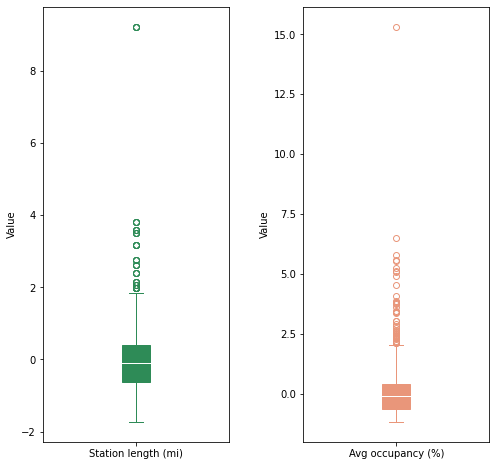

In [29]:
# Numecial attribute summary
snc = df3.select('scaled_numerical_col').collect()
stl = [snc[i][0][0] for i in range(len(snc))]
avo = [snc[i][0][1] for i in range(len(snc))]

stl_d, avo_d = [], []
for i in range(len(snc)):
    if i % 1000 == 0:
        stl_d.append(stl[i])
        avo_d.append(avo[i])

plt.figure(figsize =(8, 8))
plt.subplot(121)
plt.boxplot([stl_d], patch_artist=True,
            boxprops=dict(facecolor='seagreen', color='seagreen'), capprops=dict(color='seagreen'), whiskerprops=dict(color='seagreen'), 
            flierprops=dict(color='seagreen', markeredgecolor='seagreen'),medianprops=dict(color='white'))
plt.xticks(ticks=[1], labels=['Station length (mi)'])
plt.ylabel('Value')

plt.subplot(122)
plt.boxplot([avo_d], patch_artist=True,
            boxprops=dict(facecolor='darksalmon', color='darksalmon'), capprops=dict(color='darksalmon'), whiskerprops=dict(color='darksalmon'), 
            flierprops=dict(color='darksalmon', markeredgecolor='darksalmon'),medianprops=dict(color='white'))
plt.xticks(ticks=[1], labels=['Avg occupancy (%)'])
plt.ylabel('Value')

plt.subplots_adjust(wspace=0.4)
plt.show()

#### 3-2. Create pipeline to format feature columns

In [30]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Convert string columns to indices
si = StringIndexer(inputCols=['holiday', 'station'], outputCols=['holiday_index', 'station_index'])

# Convert string indices to vectors
ohe = OneHotEncoder(inputCols=['dayofweek', 'hour', 'minute', 'holiday_index', 'station_index', 'weather_condition'], outputCols=['dayofweek_vec', 'hour_vec', 'minute_vec', 'holiday_vec', 'station_vec', 'weather_condition_vec'])

# Select features and merge vectors into a single array
va = VectorAssembler(inputCols=['dayofweek_vec', 'hour_vec', 'minute_vec', 'holiday_vec', 'station_vec', 'weather_condition_vec', 'scaled_numerical_col'], outputCol='features', handleInvalid='keep')

In [31]:
# Create pipeline to format feature columns
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[si, ohe, va])
df3 = pipeline.fit(df3).transform(df3)
df3 = df3.select('features', 'traffic_condition')
df3.show(10, truncate=130)

+--------------------------------------------------------------------------------------------------------------------------+-----------------+
|                                                                                                                  features|traffic_condition|
+--------------------------------------------------------------------------------------------------------------------------+-----------------+
|(493,[2,7,30,85,86,478,490,491,492],[1.0,1.0,1.0,1.0,1.0,1.0,-0.7621441621336138,-0.9877527594859337,0.10542949991422551])|                0|
|(493,[2,7,35,85,86,478,490,491,492],[1.0,1.0,1.0,1.0,1.0,1.0,-0.7621441621336138,-1.0464592605686303,0.10542949991422551])|                0|
| (493,[2,7,40,85,86,478,490,491,492],[1.0,1.0,1.0,1.0,1.0,1.0,-0.7621441621336138,-1.017106010027282,0.10542949991422551])|                0|
|(493,[2,7,45,85,86,478,490,491,492],[1.0,1.0,1.0,1.0,1.0,1.0,-0.7621441621336138,-0.9608456131563644,0.10542949991422551])|                0|

#### 3-3. Data undersampling

In [32]:
# Class count before undersampling
from collections import Counter

counter = Counter(df3.select('traffic_condition').collect())
print('Before undersampling:', counter)

Before undersampling: Counter({Row(traffic_condition=0): 1416535, Row(traffic_condition=1): 140295, Row(traffic_condition=2): 27746})


In [33]:
# Random undersampling
class0_df = df3.filter(col('traffic_condition') == 0)
class1_df = df3.filter(col('traffic_condition') == 1)
class2_df = df3.filter(col('traffic_condition') == 2)

ratio_2_to_0 = round(class2_df.count()/class0_df.count(), 2)
ratio_2_to_1 = round(class2_df.count()/class1_df.count(), 2)

sampled_class0_df = class0_df.sample(withReplacement=False, fraction=ratio_2_to_0, seed=11)
sampled_class1_df = class1_df.sample(withReplacement=False, fraction=ratio_2_to_1, seed=11)
df3 = sampled_class0_df.unionAll(sampled_class1_df).unionAll(class2_df)

In [34]:
# Class count after undersampling
counter = Counter(df3.select('traffic_condition').collect())
print('After undersampling:', counter)

After undersampling: Counter({Row(traffic_condition=0): 28399, Row(traffic_condition=1): 27889, Row(traffic_condition=2): 27746})


#### 3-4. Data reduction using PCA

In [35]:
# PCA dimensionality reduction
from pyspark.ml.feature import PCA

pca = PCA(k=30, inputCol='features', outputCol='pca_features')
# Explained variance for k=30: sum(pca.fit(df3).explainedVariance) = 92.38%
# Eigenvalues: [0.5371, 0.133, 0.0983, 0.0185, 0.0133, 0.012, 0.0092, 0.0086, 0.0073, 0.0067, 0.0058, 0.0045, 0.0045, 0.0044, 0.0044, 0.0044, 0.0044, 0.0044, 0.0043, 0.0043, 0.0043, 0.0043, 0.0042, 0.0039, 0.0036, 0.0033, 0.0032, 0.0029, 0.0024, 0.0024]

df3 = pca.fit(df3).transform(df3).cache()
df3.show(10)

+--------------------+-----------------+--------------------+
|            features|traffic_condition|        pca_features|
+--------------------+-----------------+--------------------+
|(493,[2,12,55,85,...|                0|[-0.5906990621047...|
|(493,[2,23,85,86,...|                0|[-1.1102308057505...|
|(493,[2,24,65,85,...|                0|[-1.0983668063035...|
|(493,[2,25,55,85,...|                0|[-1.0511147787109...|
|(493,[3,17,55,85,...|                0|[-0.0031274042634...|
|(493,[3,18,40,85,...|                0|[-0.3644483652530...|
|(493,[3,21,75,85,...|                0|[-0.8022917608611...|
|(493,[3,24,45,85,...|                0|[-0.7714454231794...|
|(493,[3,27,70,85,...|                0|[-1.2078685957209...|
|(493,[4,13,80,85,...|                0|[0.91540968286047...|
+--------------------+-----------------+--------------------+
only showing top 10 rows



In [36]:
# Sample screenshots
print(f"Feature dimension before PCA dimensionality reduction: {len(df3.select('features').collect()[0][0])}\n")
print(f"Original feature vectors:")
df3.select('features').show(3, truncate=False, vertical=True)
print()
print(f"Feature dimension after PCA dimensionality reduction: {len(df3.select('pca_features').collect()[0][0])}\n")
print(f"PCA'd feature vectors:")
df3.select('pca_features').show(3, truncate=False, vertical=True)

Feature dimension before PCA dimensionality reduction: 493

Original feature vectors:
-RECORD 0-------------------------------------------------------------------------------------------------------------------------------
 features | (493,[2,12,55,85,86,490,491,492],[1.0,1.0,1.0,1.0,1.0,-0.7621441621336138,0.6486909581942367,1.2945572283684723])           
-RECORD 1-------------------------------------------------------------------------------------------------------------------------------
 features | (493,[2,23,85,86,478,490,491,492],[1.0,1.0,1.0,1.0,1.0,-0.7621441621336138,-0.19276889065774924,1.231971558449829])         
-RECORD 2-------------------------------------------------------------------------------------------------------------------------------
 features | (493,[2,24,65,85,86,482,490,491,492],[1.0,1.0,1.0,1.0,1.0,1.0,-0.7621441621336138,-0.30284358018780566,1.1537394710515232]) 
only showing top 3 rows


Feature dimension after PCA dimensionality reduction: 30

PCA'd fe

###
### 4. Modeling and Evaluation

In [37]:
# Train-test split (Data preparation)
train, test = df3.select('pca_features', 'traffic_condition').randomSplit([0.9, 0.1], seed=11)
train.show(10)

+--------------------+-----------------+
|        pca_features|traffic_condition|
+--------------------+-----------------+
|[-1.9584105914873...|                0|
|[-1.9174997691366...|                0|
|[-1.9116408195327...|                0|
|[-1.8491240706420...|                0|
|[-1.8199178448303...|                0|
|[-1.7983687775158...|                0|
|[-1.7923460180143...|                0|
|[-1.7729759061657...|                0|
|[-1.7584689015467...|                0|
|[-1.7563765868654...|                0|
+--------------------+-----------------+
only showing top 10 rows



#### 4-1. Logistic regression

In [38]:
# K-fold cross validation + grid search
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

model = LogisticRegression(featuresCol='pca_features', labelCol='traffic_condition', predictionCol='prediction')
grid = ParamGridBuilder().addGrid(model.maxIter, [100]).addGrid(model.thresholds, [[0.5, 0.5, 0.5]]).build()
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='traffic_condition', metricName='accuracy')

lr_cv = CrossValidator(estimator=model, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3, seed=11).fit(train)

In [39]:
# Best model parameters
lr_cv_result = list(zip(lr_cv.avgMetrics, grid))
lr_cv_result.sort(key=lambda x: (-x[0], str(x[1])), reverse=False)

print(f'Best model accuracy: {lr_cv_result[0][0]:.4f}\n')
print(f'Best model parameters:\n{lr_cv_result[0][1]}')

Best model accuracy: 0.8723

Best model parameters:
{Param(parent='LogisticRegression_7ed26e47d137', name='maxIter', doc='max number of iterations (>= 0).'): 100, Param(parent='LogisticRegression_7ed26e47d137', name='thresholds', doc="Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is the original probability of that class and t is the class's threshold."): [0.5, 0.5, 0.5]}


In [40]:
# Use the best model to make predictions on the test set
lr_model = lr_cv.bestModel

lr_pred = lr_model.transform(test)
lr_pred.select('pca_features', 'traffic_condition', 'prediction').show(5)

+--------------------+-----------------+----------+
|        pca_features|traffic_condition|prediction|
+--------------------+-----------------+----------+
|[-1.7284774205009...|                0|       0.0|
|[-1.7228361722095...|                0|       0.0|
|[-1.7227574850183...|                0|       0.0|
|[-1.7149722273987...|                0|       0.0|
|[-1.6860075637738...|                0|       0.0|
+--------------------+-----------------+----------+
only showing top 5 rows



In [42]:
# Test set results
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = lr_pred.withColumn('traffic_condition', lr_pred['traffic_condition'].cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction', 'traffic_condition']).rdd.map(tuple)
metrics = MulticlassMetrics(predictionAndLabels)

print('Confusion matrix')
print(metrics.confusionMatrix().toArray())  # Column labels are prediction classes
print()
print(f' Accuracy -  {metrics.accuracy:.4f}')
print(f'Precision -  Class 0: {metrics.precision(0.0):.4f},  Class 1: {metrics.precision(1.0):.4f},  Class 2: {metrics.precision(2.0):.4f}')
print(f'   Recall -  Class 0: {metrics.recall(0.0):.4f},  Class 1: {metrics.recall(1.0):.4f},  Class 2: {metrics.recall(2.0):.4f}')
print(f' F1 score -  Class 0: {metrics.fMeasure(0.0):.4f},  Class 1: {metrics.fMeasure(1.0):.4f},  Class 2: {metrics.fMeasure(2.0):.4f}')

Confusion matrix
[[2528.  299.    5.]
 [ 300. 2282.  222.]
 [  16.  231. 2415.]]

 Accuracy -  0.8707
Precision -  Class 0: 0.8889,  Class 1: 0.8115,  Class 2: 0.9141
   Recall -  Class 0: 0.8927,  Class 1: 0.8138,  Class 2: 0.9072
 F1 score -  Class 0: 0.8908,  Class 1: 0.8127,  Class 2: 0.9106


#### 4-2. Random forest

In [93]:
# K-fold cross validation + grid search
from pyspark.ml.classification import RandomForestClassifier

model = RandomForestClassifier(featuresCol='pca_features', labelCol='traffic_condition', predictionCol='prediction', seed=11)
grid = ParamGridBuilder().addGrid(model.maxDepth, [10]).addGrid(model.numTrees, [100]).addGrid(model.featureSubsetStrategy, ['log2']).build()
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='traffic_condition', metricName='accuracy')

rf_cv = CrossValidator(estimator=model, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3, seed=11).fit(train)

In [94]:
# Best model parameters
rf_cv_result = list(zip(rf_cv.avgMetrics, grid))
rf_cv_result.sort(key=lambda x: (-x[0], str(x[1])), reverse=False)

print(f'Best model accuracy: {rf_cv_result[0][0]:.4f}\n')
print(f'Best model parameters:\n{rf_cv_result[0][1]}')

Best model accuracy: 0.8808

Best model parameters:
{Param(parent='RandomForestClassifier_b4efcbfba136', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='RandomForestClassifier_b4efcbfba136', name='numTrees', doc='Number of trees to train (>= 1).'): 100, Param(parent='RandomForestClassifier_b4efcbfba136', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). def

In [95]:
# Use the best model to make predictions on the test set
rf_model = rf_cv.bestModel

rf_pred = rf_model.transform(test)
rf_pred.select('pca_features', 'traffic_condition', 'prediction').show(5)

+--------------------+-----------------+----------+
|        pca_features|traffic_condition|prediction|
+--------------------+-----------------+----------+
|[-1.7284774205009...|                0|       0.0|
|[-1.7228361722095...|                0|       0.0|
|[-1.7227574850183...|                0|       0.0|
|[-1.7149722273987...|                0|       0.0|
|[-1.6860075637738...|                0|       0.0|
+--------------------+-----------------+----------+
only showing top 5 rows



In [96]:
# Feature importance
rf_model.featureImportances

SparseVector(30, {0: 0.6115, 1: 0.0552, 2: 0.0969, 3: 0.0199, 4: 0.0323, 5: 0.0195, 6: 0.0164, 7: 0.0126, 8: 0.0149, 9: 0.0151, 10: 0.01, 11: 0.0024, 12: 0.0015, 13: 0.0019, 14: 0.0056, 15: 0.0013, 16: 0.0012, 17: 0.0013, 18: 0.0014, 19: 0.0012, 20: 0.0019, 21: 0.0011, 22: 0.0095, 23: 0.0175, 24: 0.0064, 25: 0.0123, 26: 0.0066, 27: 0.0043, 28: 0.0122, 29: 0.006})

In [97]:
# Test set results
predictionAndLabels = rf_pred.withColumn('traffic_condition', rf_pred['traffic_condition'].cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction', 'traffic_condition']).rdd.map(tuple)
metrics = MulticlassMetrics(predictionAndLabels)

print('Confusion matrix')
print(metrics.confusionMatrix().toArray())  # Column labels are prediction classes
print()
print(f' Accuracy -  {metrics.accuracy:.4f}')
print(f'Precision -  Class 0: {metrics.precision(0.0):.4f},  Class 1: {metrics.precision(1.0):.4f},  Class 2: {metrics.precision(2.0):.4f}')
print(f'   Recall -  Class 0: {metrics.recall(0.0):.4f},  Class 1: {metrics.recall(1.0):.4f},  Class 2: {metrics.recall(2.0):.4f}')
print(f' F1 score -  Class 0: {metrics.fMeasure(0.0):.4f},  Class 1: {metrics.fMeasure(1.0):.4f},  Class 2: {metrics.fMeasure(2.0):.4f}')

Confusion matrix
[[2541.  285.    6.]
 [ 308. 2254.  242.]
 [  14.  149. 2499.]]

 Accuracy -  0.8790
Precision -  Class 0: 0.8875,  Class 1: 0.8385,  Class 2: 0.9097
   Recall -  Class 0: 0.8972,  Class 1: 0.8039,  Class 2: 0.9388
 F1 score -  Class 0: 0.8924,  Class 1: 0.8208,  Class 2: 0.9240


#### 4-3. Naive Bayes

In [48]:
# K-fold cross validation + grid search
from pyspark.ml.classification import NaiveBayes

model = NaiveBayes(featuresCol='pca_features', labelCol='traffic_condition', predictionCol='prediction', modelType='gaussian')
grid = ParamGridBuilder().addGrid(model.smoothing, [0.5, 1.0]).build()
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='traffic_condition', metricName='accuracy')

nb_cv = CrossValidator(estimator=model, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3, seed=11).fit(train)

In [49]:
# Best model parameters
nb_cv_result = list(zip(nb_cv.avgMetrics, grid))
nb_cv_result.sort(key=lambda x: (-x[0], str(x[1])), reverse=False)

print(f'Best model accuracy: {nb_cv_result[0][0]:.4f}\n')
print(f'Best model parameters:\n{nb_cv_result[0][1]}')

Best model accuracy: 0.8088

Best model parameters:
{Param(parent='NaiveBayes_5958225555cd', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.5}


In [50]:
# Use the best model to make predictions on the test set
nb_model = nb_cv.bestModel

nb_pred = nb_model.transform(test)
nb_pred.select('pca_features', 'traffic_condition', 'prediction').show(5)

+--------------------+-----------------+----------+
|        pca_features|traffic_condition|prediction|
+--------------------+-----------------+----------+
|[-1.7284774205009...|                0|       0.0|
|[-1.7228361722095...|                0|       0.0|
|[-1.7227574850183...|                0|       0.0|
|[-1.7149722273987...|                0|       0.0|
|[-1.6860075637738...|                0|       0.0|
+--------------------+-----------------+----------+
only showing top 5 rows



In [51]:
# Test set results
predictionAndLabels = nb_pred.withColumn('traffic_condition', nb_pred['traffic_condition'].cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction', 'traffic_condition']).rdd.map(tuple)
metrics = MulticlassMetrics(predictionAndLabels)

print('Confusion matrix')
print(metrics.confusionMatrix().toArray())  # Column labels are prediction classes
print()
print(f' Accuracy -  {metrics.accuracy:.4f}')
print(f'Precision -  Class 0: {metrics.precision(0.0):.4f},  Class 1: {metrics.precision(1.0):.4f},  Class 2: {metrics.precision(2.0):.4f}')
print(f'   Recall -  Class 0: {metrics.recall(0.0):.4f},  Class 1: {metrics.recall(1.0):.4f},  Class 2: {metrics.recall(2.0):.4f}')
print(f' F1 score -  Class 0: {metrics.fMeasure(0.0):.4f},  Class 1: {metrics.fMeasure(1.0):.4f},  Class 2: {metrics.fMeasure(2.0):.4f}')

Confusion matrix
[[2280.  529.   23.]
 [ 518. 2017.  269.]
 [  20.  250. 2392.]]

 Accuracy -  0.8061
Precision -  Class 0: 0.8091,  Class 1: 0.7214,  Class 2: 0.8912
   Recall -  Class 0: 0.8051,  Class 1: 0.7193,  Class 2: 0.8986
 F1 score -  Class 0: 0.8071,  Class 1: 0.7204,  Class 2: 0.8949


#### 4-4. Linear SVC

In [52]:
# K-fold cross validation + grid search
from pyspark.ml.classification import LinearSVC, OneVsRest

model = LinearSVC(featuresCol='pca_features', labelCol='traffic_condition', predictionCol='prediction')
ovr = OneVsRest(featuresCol='pca_features', labelCol='traffic_condition', predictionCol='prediction', classifier=model)
grid = ParamGridBuilder().addGrid(model.maxIter, [50, 150]).build()
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='traffic_condition', metricName='accuracy')

svc_cv = CrossValidator(estimator=ovr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3, seed=11).fit(train)

In [53]:
# Best model parameters
svc_cv_result = list(zip(svc_cv.avgMetrics, grid))
svc_cv_result.sort(key=lambda x: (-x[0], str(x[1])), reverse=False)

print(f'Best model accuracy: {svc_cv_result[0][0]:.4f}\n')
print(f'Best model parameters:\n{svc_cv_result[0][1]}')

Best model accuracy: 0.8144

Best model parameters:
{Param(parent='LinearSVC_9aff91e8794f', name='maxIter', doc='max number of iterations (>= 0).'): 150}


In [54]:
# Use the best model to make predictions on the test set
svc_model = svc_cv.bestModel

svc_pred = svc_model.transform(test)
svc_pred.select('pca_features', 'traffic_condition', 'prediction').show(5)

+--------------------+-----------------+----------+
|        pca_features|traffic_condition|prediction|
+--------------------+-----------------+----------+
|[-1.7284774205009...|                0|       0.0|
|[-1.7228361722095...|                0|       0.0|
|[-1.7227574850183...|                0|       0.0|
|[-1.7149722273987...|                0|       0.0|
|[-1.6860075637738...|                0|       0.0|
+--------------------+-----------------+----------+
only showing top 5 rows



In [55]:
# Test set results
predictionAndLabels = svc_pred.withColumn('traffic_condition', svc_pred['traffic_condition'].cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction', 'traffic_condition']).rdd.map(tuple)
metrics = MulticlassMetrics(predictionAndLabels)

print('Confusion matrix')
print(metrics.confusionMatrix().toArray())  # Column labels are prediction classes
print()
print(f' Accuracy -  {metrics.accuracy:.4f}')
print(f'Precision -  Class 0: {metrics.precision(0.0):.4f},  Class 1: {metrics.precision(1.0):.4f},  Class 2: {metrics.precision(2.0):.4f}')
print(f'   Recall -  Class 0: {metrics.recall(0.0):.4f},  Class 1: {metrics.recall(1.0):.4f},  Class 2: {metrics.recall(2.0):.4f}')
print(f' F1 score -  Class 0: {metrics.fMeasure(0.0):.4f},  Class 1: {metrics.fMeasure(1.0):.4f},  Class 2: {metrics.fMeasure(2.0):.4f}')

Confusion matrix
[[2735.   91.    6.]
 [ 787. 1427.  590.]
 [  31.   82. 2549.]]

 Accuracy -  0.8087
Precision -  Class 0: 0.7698,  Class 1: 0.8919,  Class 2: 0.8105
   Recall -  Class 0: 0.9657,  Class 1: 0.5089,  Class 2: 0.9576
 F1 score -  Class 0: 0.8567,  Class 1: 0.6480,  Class 2: 0.8779
